# Integration analysis (skin + brain + microglia)

Goal: compare **stress/emotional activation** across three biological layers.

Important: WESAD, DENS, and GSE99074 are different cohorts, so this notebook integrates them by building **comparable layer-level scores** (not by joining on the same subjects).


In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().resolve().parents[0]
DATA_ROOT = PROJECT_ROOT / "data"
MULTISCALE_DIR = DATA_ROOT / "multiscale"
OUT_DIR = MULTISCALE_DIR / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

MULTISCALE_DIR, OUT_DIR


(PosixPath('/Users/yuliasamoilovich/Desktop/neuro_project/data/multiscale'),
 PosixPath('/Users/yuliasamoilovich/Desktop/neuro_project/data/multiscale/processed'))

In [2]:
# Load per-window / per-sample tables
dens_path = MULTISCALE_DIR / "dens_brain.csv"
wesad_path = MULTISCALE_DIR / "wesad_skin.csv"
microglia_path = MULTISCALE_DIR / "microglia_cell.csv"

dens = pd.read_csv(dens_path)
wesad = pd.read_csv(wesad_path)
microglia = pd.read_csv(microglia_path)

print("dens rows:", len(dens), "subjects:", dens["subject_id"].nunique())
print("wesad rows:", len(wesad), "subjects:", wesad["subject_id"].nunique())
print("microglia rows:", len(microglia), "samples:", microglia["subject_id"].nunique())

display(dens.head())
display(wesad.head())
display(microglia.head())


dens rows: 141 subjects: 8
wesad rows: 7105 subjects: 15
microglia rows: 38 samples: 38


,subject_id,layer,start,end,raw_label,label,delta_power_mean,delta_power_std,theta_power_mean,theta_power_std,alpha_power_mean,alpha_power_std,beta_power_mean,beta_power_std,gamma_power_mean,gamma_power_std,alpha_asym_F4_minus_F3,label_code
0,sub-mit003,brain,494.0,498.0,neutral_1_1,baseline,1.438120e-10,7.396516e-10,5.813248e-11,5.630410e-10,2.818884e-11,2.689121e-10,5.832071e-12,5.370279e-11,1.002668e-12,2.698820e-12,NaN,1
1,sub-mit003,brain,496.0,500.0,neutral_1_1,baseline,6.111161e-11,6.305845e-10,6.039984e-11,6.574757e-10,3.714237e-11,3.805651e-10,8.602921e-12,8.816902e-11,9.562058e-13,2.985722e-12,NaN,1
2,sub-mit003,brain,594.0,598.0,12_2,amusement,1.959582e-10,1.164204e-09,1.492094e-10,1.573993e-09,8.084928e-11,8.826437e-10,2.042977e-11,2.127988e-10,2.466468e-12,1.355400e-11,NaN,0
3,sub-mit003,brain,714.0,718.0,8_3,amusement,8.661912e-11,8.292716e-10,9.411987e-11,1.019375e-09,5.145748e-11,5.135080e-10,1.324472e-11,1.286882e-10,2.136560e-12,9.917308e-12,NaN,0
4,sub-mit003,brain,716.0,720.0,8_3,amusement,1.566752e-10,1.617828e-09,2.153226e-10,2.382630e-09,1.304720e-10,1.393702e-09,3.173021e-11,3.300556e-10,3.307103e-12,1.804436e-11,NaN,0


,subject_id,layer,start,end,label,label_code,eda_mean,eda_std,eda_tonic_median,eda_phasic_mean,...,eda_peak_amp_mean,hr_mean,hr_std,hr_na_ratio,acc_mean,acc_std,acc_energy,acc_pct_movement,temp_mean,temp_slope
0,S2,skin,2017-05-22 07:15:25+00:00,2017-05-22 07:15:55+00:00,baseline,1.0,0.482373,0.049584,0.490420,0.029246,...,0.204667,85.676914,6.600797,0.330579,0.981821,0.050897,0.315549,0.033058,46.580579,-0.550508
1,S2,skin,2017-05-22 07:15:40+00:00,2017-05-22 07:16:10+00:00,baseline,1.0,0.554383,0.149962,0.493591,0.006027,...,0.381916,81.319256,1.903322,0.000000,0.995092,0.128024,2.019984,0.264463,35.066694,-0.000787
2,S2,skin,2017-05-22 07:15:55+00:00,2017-05-22 07:16:25+00:00,baseline,1.0,0.631755,0.153339,0.643049,0.003338,...,0.186843,81.214298,1.394495,0.000000,1.011927,0.266061,8.682833,0.611570,35.150992,0.003365
3,S2,skin,2017-05-22 07:16:10+00:00,2017-05-22 07:16:40+00:00,baseline,1.0,0.777905,0.178989,0.767257,0.001693,...,0.086938,83.591322,1.479529,0.000000,1.052124,0.334915,14.047696,0.818182,35.357107,0.003509
4,S2,skin,2017-05-22 07:16:25+00:00,2017-05-22 07:16:55+00:00,baseline,1.0,1.105101,0.235876,1.143987,-0.010162,...,0.093037,86.014463,1.474511,0.000000,1.086563,0.304614,11.482316,0.867769,35.483471,0.001482


,subject_id,layer,age,tissue,inflammation_score_raw,inflammation_score_age_adjusted
0,GSM3081106,cell,78,microglia,0.446986,0.658813
1,GSM3081107,cell,78,microglia,0.598831,0.902291
2,GSM3081108,cell,56,microglia,0.095280,0.201268
3,GSM3081109,cell,62,microglia,-0.660404,-1.039456
4,GSM3081110,cell,77,microglia,-0.903781,-1.502246


## 1) Define simple layer scores

- **Skin (WESAD)**: arousal proxy from `EDA` and `HR` during *stress* vs *baseline*.
- **Brain (DENS EEG)**: emotion activation proxy from `beta/gamma` vs `alpha` during *amusement* vs *baseline*.
- **Microglia (GSE99074)**: `inflammation_score_age_adjusted` (already age residualized).

These are intentionally lightweight so you can iterate on the scoring definitions later.


In [3]:
def zscore(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mu = s.mean()
    sd = s.std()
    if sd is None or sd == 0 or np.isnan(sd):
        return s * np.nan
    return (s - mu) / sd


def effect_between_labels(df: pd.DataFrame, value_col: str, pos_label: str, neg_label: str) -> float:
    pos = pd.to_numeric(df.loc[df["label"] == pos_label, value_col], errors="coerce").dropna()
    neg = pd.to_numeric(df.loc[df["label"] == neg_label, value_col], errors="coerce").dropna()
    if len(pos) == 0 or len(neg) == 0:
        return np.nan
    return float(pos.mean() - neg.mean())


In [4]:
# --- WESAD skin stress score ---
wesad = wesad.copy()
wesad["eda_z"] = wesad.groupby("subject_id")["eda_mean"].transform(zscore)
wesad["hr_z"] = wesad.groupby("subject_id")["hr_mean"].transform(zscore)
wesad["skin_arousal"] = wesad["eda_z"] + wesad["hr_z"]

wesad_subject = (
    wesad.groupby("subject_id")
    .apply(lambda d: pd.Series({
        "layer": "skin",
        "score": effect_between_labels(d, "skin_arousal", pos_label="stress", neg_label="baseline"),
        "n_windows": len(d),
    }))
    .reset_index()
)
wesad_subject["dataset"] = "WESAD"
wesad_subject["score_name"] = "skin_stress_effect"

display(wesad_subject.head())
print("WESAD usable subjects:", wesad_subject["score"].notna().sum(), "/", len(wesad_subject))


/var/folders/0x/4j2_4x1s2z5f4jnxwrvs2d3h0000gn/T/ipykernel_35473/1665891218.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,subject_id,layer,score,n_windows,dataset,score_name
0,S10,skin,0.448939,453,WESAD,skin_stress_effect
1,S11,skin,2.013450,429,WESAD,skin_stress_effect
2,S13,skin,1.483916,456,WESAD,skin_stress_effect
3,S14,skin,-2.365108,464,WESAD,skin_stress_effect
4,S15,skin,-2.081313,441,WESAD,skin_stress_effect


WESAD usable subjects: 15 / 15


In [5]:
# --- DENS brain activation score ---
# Note: DENS labels here are baseline/amusement; treat this as "emotional activation" (not stress).
dens = dens.copy()

for c in ["alpha_power_mean", "beta_power_mean", "gamma_power_mean"]:
    dens[c] = pd.to_numeric(dens[c], errors="coerce")

dens["alpha_z"] = dens.groupby("subject_id")["alpha_power_mean"].transform(zscore)
dens["beta_z"] = dens.groupby("subject_id")["beta_power_mean"].transform(zscore)
dens["gamma_z"] = dens.groupby("subject_id")["gamma_power_mean"].transform(zscore)

# Simple activation proxy: higher beta+gamma, lower alpha
dens["brain_activation"] = dens["beta_z"] + dens["gamma_z"] - dens["alpha_z"]

dens_subject = (
    dens.groupby("subject_id")
    .apply(lambda d: pd.Series({
        "layer": "brain",
        "score": effect_between_labels(d, "brain_activation", pos_label="amusement", neg_label="baseline"),
        "n_windows": len(d),
    }))
    .reset_index()
)
dens_subject["dataset"] = "DENS"
dens_subject["score_name"] = "brain_amusement_effect"

display(dens_subject.head())
print("DENS usable subjects:", dens_subject["score"].notna().sum(), "/", len(dens_subject))


/var/folders/0x/4j2_4x1s2z5f4jnxwrvs2d3h0000gn/T/ipykernel_35473/118097572.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,subject_id,layer,score,n_windows,dataset,score_name
0,sub-mit003,brain,-0.477996,19,DENS,brain_amusement_effect
1,sub-mit004,brain,-0.456106,18,DENS,brain_amusement_effect
2,sub-mit061,brain,-0.761133,18,DENS,brain_amusement_effect
3,sub-mit076,brain,0.320979,18,DENS,brain_amusement_effect
4,sub-mit117,brain,-0.496862,16,DENS,brain_amusement_effect


DENS usable subjects: 7 / 8


In [6]:
# --- Microglia cell inflammation score (already age-adjusted) ---
microglia = microglia.copy()

if "inflammation_score_age_adjusted" not in microglia.columns:
    raise ValueError("Expected 'inflammation_score_age_adjusted' in microglia_cell.csv")

microglia_samples = microglia.rename(columns={"subject_id": "sample_id"}).copy()
microglia_samples["layer"] = "cell"
microglia_samples["dataset"] = "GSE99074"
microglia_samples["score_name"] = "microglia_inflammation_age_adjusted"
microglia_samples["score"] = pd.to_numeric(microglia_samples["inflammation_score_age_adjusted"], errors="coerce")
microglia_samples["n_windows"] = 1

display(microglia_samples[["sample_id", "layer", "dataset", "score_name", "score"]].head())


,sample_id,layer,dataset,score_name,score
0,GSM3081106,cell,GSE99074,microglia_inflammation_age_adjusted,0.658813
1,GSM3081107,cell,GSE99074,microglia_inflammation_age_adjusted,0.902291
2,GSM3081108,cell,GSE99074,microglia_inflammation_age_adjusted,0.201268
3,GSM3081109,cell,GSE99074,microglia_inflammation_age_adjusted,-1.039456
4,GSM3081110,cell,GSE99074,microglia_inflammation_age_adjusted,-1.502246


## 2) Standardize scores and visualize across layers

We z-score **within each dataset** so the three layers are comparable on one plot.


In [7]:
layer_scores = pd.concat(
    [
        wesad_subject.rename(columns={"subject_id": "unit_id"})[["unit_id", "layer", "dataset", "score_name", "score", "n_windows"]],
        dens_subject.rename(columns={"subject_id": "unit_id"})[["unit_id", "layer", "dataset", "score_name", "score", "n_windows"]],
        microglia_samples.rename(columns={"sample_id": "unit_id"})[["unit_id", "layer", "dataset", "score_name", "score", "n_windows"]],
    ],
    ignore_index=True,
)

layer_scores["score_z_within_dataset"] = layer_scores.groupby("dataset")["score"].transform(zscore)

out_scores = OUT_DIR / "layer_scores.tsv"
layer_scores.to_csv(out_scores, sep="\t", index=False)
print("Wrote:", out_scores)

summary = (
    layer_scores.groupby(["dataset", "layer", "score_name"], dropna=False)
    .agg(n_units=("unit_id", "nunique"), mean_score=("score", "mean"), std_score=("score", "std"))
    .reset_index()
)
out_summary = OUT_DIR / "layer_summary.tsv"
summary.to_csv(out_summary, sep="\t", index=False)
print("Wrote:", out_summary)

display(summary)


Wrote: /Users/yuliasamoilovich/Desktop/neuro_project/data/multiscale/processed/layer_scores.tsv
Wrote: /Users/yuliasamoilovich/Desktop/neuro_project/data/multiscale/processed/layer_summary.tsv


,dataset,layer,score_name,n_units,mean_score,std_score
0,DENS,brain,brain_amusement_effect,8,-7.779983e-02,0.837073
1,GSE99074,cell,microglia_inflammation_age_adjusted,38,1.168656e-17,1.000000
2,WESAD,skin,skin_stress_effect,15,-2.883340e-01,1.155832


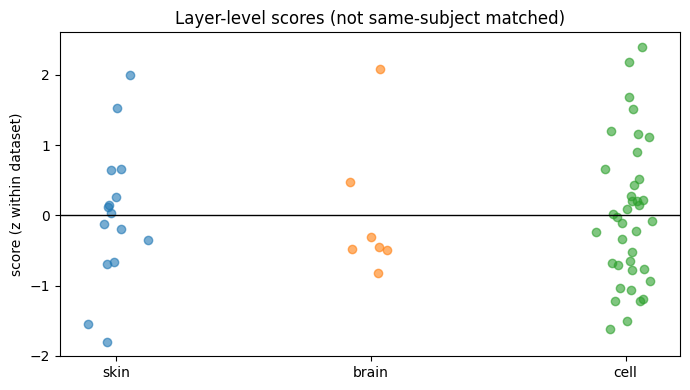

In [8]:
plot_df = layer_scores.dropna(subset=["score_z_within_dataset"]).copy()

order = ["skin", "brain", "cell"]
plt.figure(figsize=(7, 4))
for i, layer in enumerate(order):
    y = plot_df.loc[plot_df["layer"] == layer, "score_z_within_dataset"].to_numpy(dtype=float)
    x = np.random.normal(loc=i, scale=0.07, size=len(y))
    plt.scatter(x, y, alpha=0.6, label=layer)

plt.xticks(range(len(order)), order)
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("score (z within dataset)")
plt.title("Layer-level scores (not same-subject matched)")
plt.tight_layout()
plt.show()
